In [1]:
import os
import csv
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../"))

/kaggle/working
['config', 'lib', 'working', 'input']


In [ ]:
def clean_data(df):
    #since first column contains row number
#     df.drop(["Row_num"], axis=1)
    #removing  and kesEntityId as simillar fields are already present
    df = df.drop(columns=["Row_num","kesEntityId"],axis=1)
    df["Popularity"] = df["Popularity"].apply(pd.to_numeric,downcast='float')
    df["Year"] = df["Year"].apply(pd.to_numeric,downcast='unsigned')
    df["Month"] = df["Month"].apply(pd.to_numeric,downcast='unsigned')
    df = df.dropna(subset=['Venue'])
    return df

In [ ]:
# df_pub = pd.read_csv("../input/scopus-data/ProcessedScopusData.csv")
# If this doesn't work, please change it to the path where the file is locaed in your PC
df_pub = pd.read_csv("Data/ProcessedScopusData.csv")

In [ ]:
def append_pub_score(df):
    print("Unique Publications from Scopus:",len(df_pub.Title.unique()))
    # Analysing Common Publications
    vfn_list = df.Venue.unique().tolist()
    scopus_list = df_pub.Title.unique().tolist()
    count = 0
    for pub in scopus_list:
        if pub in vfn_list:
            count +=1
    print("Publications present in Dataset:",count)
    print("Shape Before",df.shape)
    df = df[df.Venue.isin(scopus_list)]
    print("Shape After",df.shape)
    #score appending
    score_dict = pd.Series(df_pub.SJR.values,index=df_pub.Title).to_dict()
    df["Publication_Rank"] = df.apply(lambda row: score_dict[row["Venue"]],axis = 1)
    return df

def extract_field(row):
    val = row["Domain"]
    index = val.rfind("FN")
    val = val[index+3:len(val)]
    val = val.strip(":}] '")
    return val

def get_num_authors(row):
    vals = row["Authors"].split("},")
    return len(vals)

In [ ]:
label_dict = {"C":0,"J":1,"CJ":2,"O":3}
def find_conference_type(row):
    if pd.isnull(row["Conference"]) and pd.isnull(row["Journal"]):
        return label_dict["O"]
    elif pd.isnull(row["Conference"]):
        return label_dict["J"]
    elif pd.isnull(row["Journal"]):
        return label_dict["C"]
    else:
        return label_dict["CJ"]

In [ ]:
def tidy_split(df, column, sep='|', keep=False):
    indexes = list()
    id_values = list()
    name_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            id_values.append(presplit)
        for value in values:
            indexes.append(i)
            val = value
            index1 = val.find("AuId")
            index2 = val.find("AfN")
            index3 = val.find("'S'")
            if index3 < index1:
                val = val[index1+4:index2]
                val = val.strip("', :")
            else:
                val = val[index1+4:index3]
                val = val.strip("', :")                
            id_values.append(val)
            index1 = value.find("AuN")
            val = value[index1+3:]
            val = val.strip("': }]")
            name_values.append(val)
    new_df = df.iloc[indexes, :].copy()
    new_df[column+"_Id"] = id_values
    new_new_df = new_df.iloc[:, :].copy()
    new_new_df[column+"_Name"] = name_values
    return new_new_df

In [ ]:
def process_year(df):
    # Make more sensible column names
    rename_dict = {"AA": "Authors", 
                   "C": "Conference", 
                   "CC": "Citation_count",
                   "ECC": "Expected_count",
                   "D": "Date", 
                   "F": "Domain", 
                   "J": "Journal", 
                   "RId": "References", 
                   "Ti": "Title", 
                   "VFN": "Venue", 
                   "W": "Words", 
                   "Y": "Year", 
                   "logprob":"Popularity",
                   "Unnamed: 0": "Row_num"}
    df.rename(index=str, columns=rename_dict, inplace=True)
    df.drop_duplicates(subset=['Title'], inplace=True)
    df["Month"] = pd.to_datetime(df["Date"]).dt.month
    df = clean_data(df)
    df = append_pub_score(df)
    df["Publication Type"] = df.apply(lambda row:find_conference_type(row),axis=1)
    df["Number_Of_authors"] = df.apply(lambda row:get_num_authors(row), axis = 1)
    return df

In [ ]:
# df = pd.read_csv("../input/mag-2007/mag_2007.csv")

In [ ]:
# df = process_year(df)

In [ ]:
# df.to_csv("mag_2007_processed.csv")

In [2]:
print(os.listdir("../input/processedmagdata"))

['mag_2018_processed.csv', 'mag_2011_processed.csv', 'mag_2013_processed.csv', 'mag_2009_processed.csv', 'mag_2008_processed.csv', 'mag_2010_processed.csv', 'mag_2014_processed.csv', 'mag_2017_processed.csv', 'mag_2016_processed.csv', 'mag_2015_processed.csv', 'mag_2007_processed.csv', 'mag_2012_processed.csv']


In [2]:
columns = ['Unnamed: 0','Authors', 'Conference','Citation_count','Date','Expected_count','Domain','Id','Journal','References','Title','Venue','Words','Year','Popularity','Month','Publication_Rank','Publication Type','Number_Of_authors']

In [3]:
df = pd.DataFrame(columns = columns)
# please give a path that works on your machine. Keep all the processed files in this path
path = "../input/processedmagdata"
for file in os.listdir(path):
#     print(file)
    df_temp = pd.read_csv(path+"/"+file)
    df = df.append(df_temp)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [4]:
df.head()

,Authors,Citation_count,Conference,Date,Domain,Expected_count,Id,Journal,Month,Number_Of_authors,Popularity,Publication Type,Publication_Rank,References,Row_num,Title,Unnamed: 0,Venue,Words,Year,kesEntityId
0,"[{'AuId': 2285399872, 'S': 1, 'AuN': 'jeanmich...",827,NaN,2018-08-01,"[{'FId': 2778867932, 'FN': 'paritaprevir'}, {'...",827,2185218296,"{'JN': 'j hepatol', 'JId': 83651209}",8,6,-16.665,1,5.633,"[2027545702, 2127685726, 2143559032, 212596379...",NaN,easl recommendations on treatment of hepatitis c,8,Journal of Hepatology,"['c', 'easl', 'hepatitis', 'recommendations', ...",2018,NaN
1,"[{'S': 1, 'AuId': 2309940897, 'AfN': 'johns ho...",820,NaN,2018-02-01,"[{'FId': 33070731, 'FN': 'toxicology'}, {'FId'...",820,2779588417,"{'JN': 'toxicol sci', 'JId': 186282544}",2,3,-16.711,1,1.538,"[2319741579, 2605278466, 2685494954, 273903073...",NaN,green toxicology know early about and avoid to...,9,Toxicological Sciences,"['avoid', 'early', 'green', 'know', 'liabiliti...",2018,NaN
2,"[{'AuId': 2139142140, 'S': 1, 'AuN': 'borja ib...",578,NaN,2018-01-07,"[{'FId': 2771771, 'FN': 'st segment'}, {'FId':...",578,2754054868,"{'JN': 'eur heart j', 'JId': 181568219}",1,50,-16.790,1,9.315,"[2166950143, 2099869131, 2105397247, 211582401...",NaN,2017 esc guidelines for the management of acut...,14,European Heart Journal,"['2017', 'acute', 'cardiology', 'elevation', '...",2018,NaN
3,"[{'AuId': 2787512318, 'S': 1, 'AuN': 'marco va...",331,NaN,2018-01-14,"[{'FId': 2780890252, 'FN': 'ticagrelor'}, {'FI...",331,2752033985,"{'JN': 'eur heart j', 'JId': 181568219}",1,18,-17.018,1,9.315,"[2136489990, 2166950143, 2097854437, 216250894...",NaN,2017 esc focused update on dual antiplatelet t...,18,European Heart Journal,"['2017', 'antiplatelet', 'artery', 'associatio...",2018,NaN
4,"[{'S': 1, 'AuId': 2235459312, 'AfN': 'centre n...",429,NaN,2018-01-22,"[{'FId': 78594624, 'FN': 'coherent control'}, ...",429,2785290892,"{'JN': 'rep progr phys', 'JId': 105282323}",1,9,-17.092,1,5.640,"[2163525631, 1978691316, 2145486367, 210200818...",NaN,coherent control of single electrons a review ...,19,Reports on Progress in Physics,"['coherent', 'control', 'current', 'electrons'...",2018,NaN


In [5]:
df = df.drop(['Unnamed: 0','kesEntityId'],axis = 1)

In [12]:
df.shape

(2633414, 19)

In [6]:
df["Publication Type"].value_counts()

1    1300446
3       2069
0       1775
Name: Publication Type, dtype: int64

In [7]:
max(df.Number_Of_authors)

500

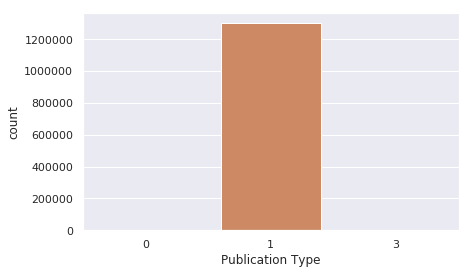

In [8]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Publication Type", data=df)

In [ ]:
# import seaborn as sns
# sns.set(style="darkgrid")
# ax = sns.countplot(x="Venue", data=df)

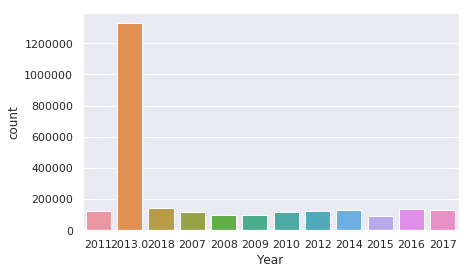

In [9]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Year", data=df)

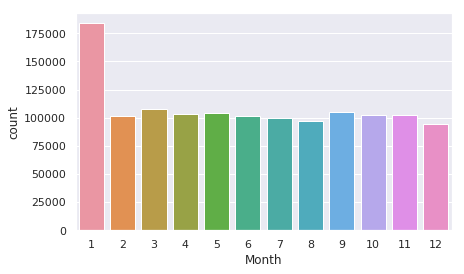

In [10]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Month", data=df)